# Notebook description
$\DeclareMathOperator{\Var}{Var}$
This notebook considers the alpha synapse. The alpha synapse is so named because it's response to a spike (modeled by a delta function) is the alpha function.

\begin{equation*}
h(t) = \frac{1}{\tau^2}te^{-t/\tau} \quad \textrm{for } t\ge0
\end{equation*}

In constructing NEF networks, we typically have an SNR and latency specification to meet. We've examined how to use these specifications to derive the required spike rates and synaptic time constants for networks constructed using a first-order (exponential) synapse. We'd like to know whether we can reduce the required firing rates by using the alpha synapse instead of a first-order synapse.

# Summary

With the most generous definition of latency, switching from first-order synapse to the alpha synapse reduces our firing rates by $2$. Defining latency as the time it takes the step response to get to $0.7153$, both synapses require the same spike rate. Using lower values (e.g. $1-e^{-1}$) to define latency requires the alpha synapse to use higher spike rates than the first-order synapse. 

Since the potential gain is so modest and the compromise in latency definition troubling, it's probably not worth our time to invest in constructing the alpha synapse.

# Setup

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import lambertw
from scipy.optimize import fsolve

def alpha(t, tau):
    """computes the spike (impulse) response of the alpha synapse"""
    ret = np.zeros_like(t)
    idx = t>=0
    ret[idx] = t[idx]*np.exp(-t[idx]/tau)/tau**2
    return ret

def step(t, tau):
    """computes the step response of the alpha synapse"""
    ret = np.zeros_like(t)
    idx = t>=0
    ret[idx] = 1-(t[idx]+tau)*np.exp(-t[idx]/tau)/tau
    return ret

def step1(t, tau):
    """computes the step response of the first-order synapse"""
    ret = np.zeros_like(t)
    idx = t>=0
    ret[idx] = 1-np.exp(-t/tau)
    return ret

def _check01(x):
    assert np.all(x>=0), 'x must be >= 0'
    assert np.all(x<=1), 'x must be <= 1'
    
def step_invtau(x, t):
    """compute the tau necessary for the alpha synapse to reach x at t"""
    _check01(x)
    assert np.all(x>0), x
    assert t>=0
    tau = -t/(1+lambertw((x-1)/np.e, -1).real)
    return tau

def step1_invtau(x, t):
    """compute the tau necessary for the first-order synapse to reach x at t"""
    _check01(x)
    assert np.all(x>0)
    assert t>=0
    tau = -t/np.log(1-x)
    return tau

def tau_a1(x):
    """computes the tau_a/tau_1 to match first-order and alpha synapse latencies"""
    if isinstance(x, (int, float)):
        x = np.array([x])
    _check01(x)
    ret = np.zeros_like(x)
    idx = np.logical_and(x>0, x<1)
    num = np.log(1-x[idx])
    den = 1+lambertw((x[idx]-1)/np.e, -1).real
    ret[idx] = num/den
    ret[x==0] = 0
    ret[x==1] = 1
    return ret

def tau_a1_inv(tat1):
    ret = fsolve(lambda x: tau_a1(x)-tat1, 0.5, )[0]
    return ret

# The alpha function

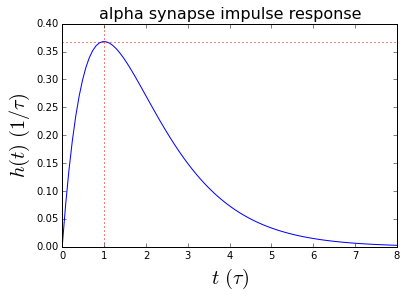

In [2]:
t = np.linspace(0, 8, 100)
h = alpha(t, 1)
plt.plot(t, h)
plt.axvline(1, c='r', ls=':')
plt.axhline(np.exp(-1), c='r', ls=':')
plt.xlabel(r'$t$ $(\tau)$', fontsize=20)
plt.ylabel(r'$h(t)$ $(1/\tau)$', fontsize=20)
plt.title('alpha synapse impulse response', fontsize=16);

Like the first-order synapse (a.k.a. exponential synapse), the alpha synapse also has unit area. To see this,

\begin{align*}
\int_{-\infty}^{\infty}h(t)dt &= \int_{0}^{\infty}\frac{1}{\tau^2}te^{-t/\tau}dt \\
 &= \frac{1}{\tau^2}\int_{0}^{\infty}te^{-t/\tau}dt \\
 &= \frac{1}{\tau^2}\left(\left[-\tau te^{-t/\tau}\right]_0^{\infty}-
    \int_{0}^{\infty}-\tau e^{-t/\tau}dt\right) & \textrm{integration by parts} \\
 &= \frac{1}{\tau^2}\left(0+\tau\int_{0}^{\infty}e^{-t/\tau}dt\right) \\
 &= \frac{1}{\tau^2}\left[-\tau^2e^{-t/\tau}\right]_{0}^{\infty} \\
 &= 1
\end{align*}

# Alpha synapse dynamics

From the impulse response, we can derive the transfer function and differential equation that governs the alpha synapse.

\begin{align*}
H(s) &= \mathcal{L}(h(t)) \\
 &= \frac{1}{\tau^2}\frac{1}{(s+\frac{1}{\tau})^2} \\
 &= \frac{1}{\tau^2}\frac{1}{(\frac{1}{\tau}(\tau s+1))^2} \\
 &= \frac{1}{(\tau s+1)^2} \\
 &= \frac{1}{\tau^2s^2+2\tau s+1} \\
\end{align*}

If we compare this result to the first-order synapse, we see that the alpha synapse arises from cascading two first-order synapses in series.

From the Laplace transform, we can derive the dynamical system

\begin{align*}
H(s) &= \frac{1}{\tau^2s^2+2\tau s+1} \\
\frac{X(s)}{U(s)} &= \frac{1}{\tau^2s^2+2\tau s+1} \\
(\tau^2s^2+2\tau s+1)X(s) &= U(s) \\
 \mathcal{L}&\updownarrow \\
\tau^2\ddot{x}+2\tau\dot{x}+x &= u \\
\end{align*}

Therefore

\begin{equation*}
\ddot{x} = -\frac{2}{\tau}\dot{x}-\frac{1}{\tau^2}x+u
\end{equation*}

We can rewrite this differential equation as a 2D dynamical system by defining state vector $\mathbf{x}=\begin{bmatrix}x_0\\x_1\end{bmatrix}$ and $x_0=\dot{x}$ and $x_1=x$ so that

\begin{align*}
\dot{x_0} &= -\frac{2}{\tau}x_0-\frac{1}{\tau^2}x_1+u \\
\dot{x_1} &= x_0
\end{align*}

\begin{align*}
\dot{
\begin{bmatrix}
x_0 \\ x_1
\end{bmatrix}}
 &=
\begin{bmatrix}
-2/\tau & 1/\tau^2 \\
1 & 0 \\
\end{bmatrix}
\begin{bmatrix}
x_0 \\ x_1
\end{bmatrix}
 +
\begin{bmatrix}
1 \\ 0
\end{bmatrix}
u
\end{align*}


# Mean, Variance, and SNR

We make use of [Campbell's theorem](../theory/campbells_theorem.ipynb) to find the mean and variance. 

\begin{align*}
E(\Sigma) &= \int_0^{\infty}\lambda\frac{1}{\tau^2}te^{-t/\tau}dt \\
 &= \lambda
\end{align*}

and

\begin{align*}
\Var(\Sigma) &= \int_0^{\infty}\lambda\left(\frac{1}{\tau^2}te^{-t/\tau}\right)^2dt \\
 &= \frac{\lambda}{\tau^4}\int_0^{\infty}t^2e^{-2t/\tau}dt \\
 &= \frac{\lambda}{\tau^4}\left(\left[-\frac{\tau}{2}t^2e^{-2t/\tau}\right]_0^\infty-
    \int_0^{\infty}-\tau te^{-2t/\tau}dt\right) & \textrm{integration by parts} \\
 &= \frac{\lambda}{\tau^4}\left(0+\tau
    \int_0^{\infty}te^{-2t/\tau}dt\right) \\
 &= \frac{\lambda}{\tau^3}\left(
    \int_0^{\infty}te^{-2t/\tau}dt\right) \\
 &= \frac{\lambda}{\tau^3}\left(\left[-\frac{\tau}{2}te^{-2t/\tau}\right]_0^\infty-
    \int_0^{\infty}-\frac{\tau}{2}e^{-2t/\tau}dt\right) & \textrm{integration by parts} \\
 &= \frac{\lambda}{\tau^3}\left(0+
    \frac{\tau}{2}\int_0^{\infty}e^{-2t/\tau}dt\right) \\
 &= \frac{\lambda}{2\tau^2}\left[-\frac{\tau}{2}e^{-2t/\tau}dt\right]_0^{\infty} \\
 &= \frac{\lambda}{4\tau} \\
\end{align*}

This yields

\begin{align*}
SNR &= \frac{\lambda}{\sqrt{\frac{\lambda}{4\tau}}} \\
 &= 2\sqrt{\lambda\tau} \\
\end{align*}

The alpha synapse has $\sqrt{2}$ improvement over the first-order synapse receiving Poisson spiking input, which has $SNR=\sqrt{2\lambda\tau}$. In other words, for fixed SNR, switching from the first-order synapse to the alpha synapse halves the value of $\lambda\tau$. Next, we'll compare the latency of the alpha synapse to the first-order synapse.

# Step response

A first order synapse will have a unit step response of $1-e^{-t/\tau}$. What is the step response of an alpha synapse? For a unit step, $U(s)=\frac{1}{s}$, so

\begin{align*}
X(s) &= H(s)U(s) \\
 &= \frac{1}{(\tau s+1)^2}\frac{1}{s} \\
 &= -\frac{\tau}{(\tau s+1)^2}-\frac{\tau}{\tau s+1}+\frac{1}{s} & \textrm{partial fraction expansion} \\
 &\updownarrow\mathcal{L} \\
x(t) &= -\tau\frac{1}{\tau^2}te^{-t/\tau}-\tau\frac{1}{\tau}e^{-t/\tau}+1 \\
 &= -\frac{1}{\tau}te^{-t/\tau}-e^{-t/\tau}+1 \\
 &= 1-\frac{1}{\tau}(t+\tau)e^{-t/\tau} \\
\end{align*}

The first-order synapse and alpha synapse unit step responses are plotted below.

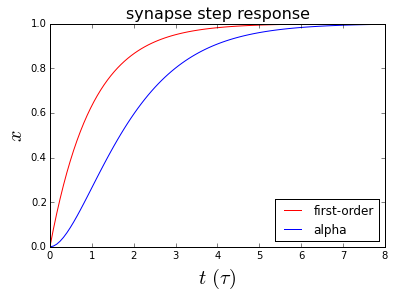

In [3]:
t = np.linspace(0, 8, 100)
x = step(t, 1)
x1 = step1(t, 1)
plt.plot(t, x1, 'r', label='first-order')
plt.plot(t, x, label='alpha')
plt.legend(loc='lower right')
plt.xlabel(r'$t$ $(\tau)$', fontsize=20)
plt.ylabel(r'$x$', fontsize=20)
plt.title('synapse step response', fontsize=16);

The alpha synapse is slower than the first order synapse. This follows from considering the transfer function. High (fast) frequencies (of which a unit step has infinitely many) are attenuated more with the alpha synapse than the first-order synapse. 

# Match latency

So far, we've seen that the alpha synapse has better SNR but is slower than the first-order synapse. To decide whether an alpha synapse yields any gains over the first-order synapse, we need to compare the synapses in terms of an SNR and latency specification. There's no standard definition of latency applicable across different kinds of dynamical systems. So for our purposes, latency is the time it takes the step response to reach a given $x\in(0,1)$. We will find the relationship between the first-order synapse time constant, $\tau_\alpha$, and the alpha synapse time constant, $\tau_1$, required to satisfy a latency specification?

For a first-order synapse, the latency as a function of $x$ is simple.

\begin{align*}
x &= 1-e^{-t/\tau} \\
t &= -\tau\ln(1-x)
\end{align*}

For the alpha synapse, the latency is more complicated.

\begin{align*}
x &= 1-\frac{1}{\tau}(t+\tau)e^{-t/\tau} \\
\left(t+\tau\right)e^{-t/\tau} &= \tau(1-x) \\
\frac{-\tau}{-\tau}(t+\tau)e^{-(t+\tau-\tau)/\tau} &= \tau(1-x) \\
-\tau\frac{-(t+\tau)}{\tau}e^{-(t+\tau)/\tau+\tau/\tau} &= \tau(1-x) \\
-\tau\frac{-(t+\tau)}{\tau}e^{-(t+\tau)/\tau}e &= \tau(1-x) \\
-\frac{t+\tau}{\tau}e^{-(t+\tau)/\tau} &= \frac{x-1}{e} \\
-\frac{t+\tau}{\tau} &= W\left(\frac{x-1}{e}\right) \\
t &= -\tau\left(1+W\left(\frac{x-1}{e}\right)\right) \\
\end{align*}

where $W(\cdot)$ is the [Lambert W function](https://en.wikipedia.org/wiki/Lambert_W_function) (specifically, the $-1$ branch of the function given the range of $x$). 

To match the latency of the first-order and alpha synapses,

\begin{align*}
-\tau_1\ln(1-x) &= -\tau_\alpha\left(1+W\left(\frac{x-1}{e}\right)\right) \\
\frac{\tau_\alpha}{\tau_1} &= \frac{\ln(1-x)}{1+W\left(\frac{x-1}{e}\right)} \\
\end{align*}

This ratio is plotted below.

tau_a/tau_1=.5 at x=0.71533


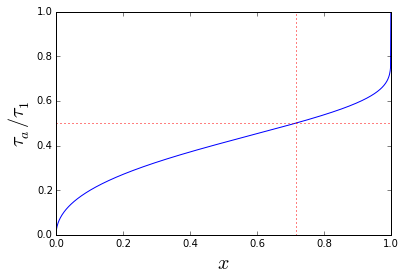

In [4]:
x = np.linspace(0, 1, 1000)
tat1 = tau_a1(x)
xcross = tau_a1_inv(.5)
plt.plot(x, tat1)
plt.axhline(0.5, c='r', ls=':')
plt.axvline(xcross, c='r', ls=':')
plt.ylim(0, 1)
plt.xlabel(r'$x$', fontsize=20)
plt.ylabel(r'$\tau_a/\tau_1$', fontsize=20);
print 'tau_a/tau_1=.5 at x=%.5f' % xcross

Recall that the alpha synapse allows us to use half the $\lambda\tau$ required by the first order synapse to satisfy the same SNR. The above plot indicates that we can halve $\tau$ and maintain the same latency only if latency is defined as the time it takes the step response to reach $71.5%$ of the steady-state value. If latency is defined from a higher percentage of the steady-state value, then we increase $\tau_a$ but lower $\lambda$. If latency from as lower percentage of the steady-state value, then we decrease $\tau_a$ but increase $\lambda$.

# Match latency and SNR

To further illustrate the previous point, we now match the latency and SNR of the alpha and first-order synapses to compare the requisite firing rates. 

\begin{align*}
SNR_\alpha &= SNR_1 \\
2\sqrt{\lambda_\alpha\tau_\alpha} &= \sqrt{2\lambda_1\tau_1} \\
4\lambda_\alpha\tau_\alpha &= 2\lambda_1\tau_1 \\
\frac{\lambda_\alpha}{\lambda_1} &= \frac{1}{2}\frac{\tau_1}{\tau_\alpha} \\
 &= \frac{1}{2}\frac{1+W\left(\frac{x-1}{e}\right)}{\ln(1-x)} \\
\end{align*}


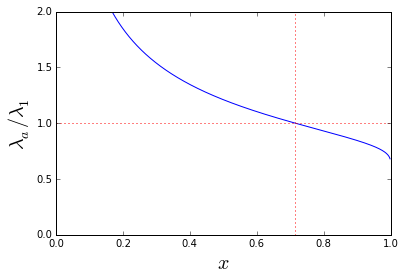

In [5]:
def lal1(x):
    ret = (1+lambertw((x-1)/np.e, -1).real)/(2*np.log(1-x))
    return ret

x = np.linspace(0, 1, 1000)[1:-2]
lama_lam1 = lal1(x)
xcross = tau_a1_inv(.5)
plt.figure(figsize=(6, 4))
plt.plot(x, lama_lam1)
plt.axhline(1, c='r', ls=':')
plt.axvline(xcross, c='r', ls=':')
plt.ylim(0, 2)
plt.xlabel(r'$x$', fontsize=20)
plt.ylabel(r'$\lambda_a/\lambda_1$', fontsize=20);

Below $x\approx0.7153$, the alpha synapse actually needs a higher spike rate than the first-order synapse to meet the latency and SNR spec. Above $x\approx0.7153$, the alpha synapse needs a lower spike rate. The minimum ratio occurs as $x\rightarrow1$

\begin{align*}
\lim_{x\rightarrow1}\frac{\lambda_\alpha}{\lambda_1} &=
    \lim_{x\rightarrow1}\frac{1}{2}\frac{1+W\left(\frac{x-1}{e}\right)}{\ln(1-x)} \\
 &= \frac{1}{2}
\end{align*}

# Appendix

Here are some supplementary sections that check the accuracy of derivations and claims made above.

## Differential equation verification
Let's verify that the impulse response is consistent with this differential equation.

\begin{align*}
h(t) &= \frac{1}{\tau^2}te^{-t/\tau} \\
\dot{h}(t) &= \frac{1}{\tau^2}\left(e^{-t/\tau}-\frac{1}{\tau}te^{-t/\tau}\right) \\
 &= \frac{1}{\tau^2}e^{-t/\tau}-\frac{1}{\tau^3}te^{-t/\tau} \\
\ddot{h}(t) &= -\frac{1}{\tau^3}e^{-t/\tau}-
    \frac{1}{\tau^3}\left(e^{-t/\tau}-\frac{1}{\tau}te^{-t/\tau}\right) \\
 &= -\frac{2}{\tau^3}e^{-t/\tau}+\frac{1}{\tau^4}te^{-t/\tau} \\
\end{align*}

Now we'll verify that

\begin{align*}
\ddot{h} &= -\frac{2}{\tau}\dot{h}-\frac{1}{\tau^2}h \\
 &=  -\frac{2}{\tau}\left(\frac{1}{\tau^2}e^{-t/\tau}-\frac{1}{\tau^3}te^{-t/\tau}\right)
    -\frac{1}{\tau^2}\frac{1}{\tau^2}te^{-t/\tau} \\
 &= -\frac{1}{\tau^3}e^{-t/\tau}+\frac{1}{\tau^4}te^{-t/\tau} \\
\end{align*}

as we found earlier.

# Latency match verification

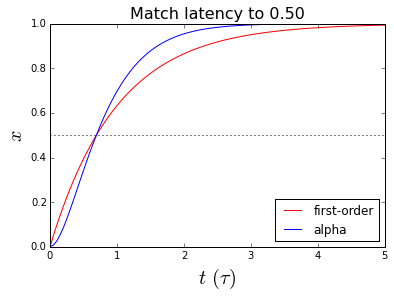

In [6]:
# check the correctness of tau_a1
tgt = .5
tau_a = tau_a1(tgt)
t = np.linspace(0, 5, 100)
x1 = step1(t, 1)
x = step(t, tau_a)
plt.plot(t, x1, 'r', label='first-order')
plt.plot(t, x, label='alpha')
plt.axhline(tgt, c='k', ls=':')
plt.legend(loc='lower right')
plt.xlabel(r'$t$ $(\tau)$', fontsize=20)
plt.ylabel(r'$x$', fontsize=20)
plt.title('Match latency to %.2f' % tgt, fontsize=16);

# Calculating tau from x, t

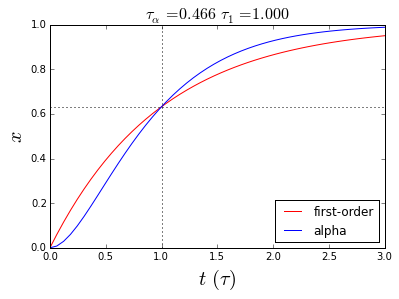

In [7]:
x_tgt = 1-np.exp(-1)
t_tgt = 1
tau = step_invtau(x_tgt, t_tgt)
tau1 = step1_invtau(x_tgt, t_tgt)
t = np.linspace(0, 3)
x = step(t, tau)
x1 = step1(t, tau1)
plt.plot(t, x1, 'r', label='first-order')
plt.plot(t, x, label='alpha')
plt.axhline(x_tgt, c='k', ls=':')
plt.axvline(t_tgt, c='k', ls=':')
plt.legend(loc='lower right')
plt.xlabel(r'$t$ $(\tau)$', fontsize=20)
plt.ylabel(r'$x$', fontsize=20)
plt.title(r'$\tau_\alpha=%.3f$ $\tau_1=%.3f$' % (tau, tau1), fontsize=16);